# **Speech Emotion Recognition**

## Problem Statement & Motivation

Identifying human emotions from audio recordings has various applications in fields of customer service, patient health monitoring and emergency services.


However, there are significant challenges due to the complex nature of emotional expression. By developing a neural network model to classify emotions from audio data, we can enable better natural and empathetic understanding between humans using technology, leading to improved user experiences and business outcomes.


For example, such a model could be used to improve customer service experience for large organizations or be used by emergency service operators to gauge emotions of callers under extreme circumstances.
Dataset


For this project, we will be primarily focusing on using the RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) dataset. This dataset contains 7,356 audio files from 24 professional actors (12 female, 12 male) vocalizing statements in a neutral North American accent while expressing 8 different emotions: calm, happy, sad, angry, fearful, disgust, surprised, and neutral.

##Link to datasets:

1. [RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song)](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio)

2. [SAVEE (Surrey Audio-Visual Expressed Emotion)](https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee)

3. [CREMA-D]



[Link to Complete Project Proposal](https://docs.google.com/document/d/1aDdbr5IF-KJ8oOediNr1NZk0wpHMOZNqJW-GkWJcqlM/edit?usp=sharing)


## Importing and Installing Packages/Libraries

In [106]:
!pip install librosa
!pip install swifter

In [107]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import tensorflow as tf
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import librosa
import librosa.display
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# To play sound in the notebook
import IPython.display as ipd

# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Loading Data and Merging all datasets

In [108]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [109]:
# Paths for data.
RAVDESS = "/content/gdrive/MyDrive/BA865 Project Data Files/RAVDESS/audio_speech_actors_01-24/"
SAVEE = "/content/gdrive/MyDrive/BA865 Project Data Files/SAVEE/"
CREMA = "/content/gdrive/MyDrive/BA865 Project Data Files/CREMA-D/"

## SAVEE Dataset

In [110]:
# SAVEE Directory
savee_dir = os.listdir(SAVEE)
savee_dir.sort()
# parse the filename to get the emotions
emotion=[]
path = []
for i in savee_dir:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error')
    path.append(SAVEE + i)


SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)

In [111]:
SAVEE_df.labels.value_counts()

labels
male_neutral     120
male_disgust      60
male_angry        60
male_fear         60
male_happy        60
male_sad          60
male_surprise     60
Name: count, dtype: int64

#### SAVEE - Sample Audio

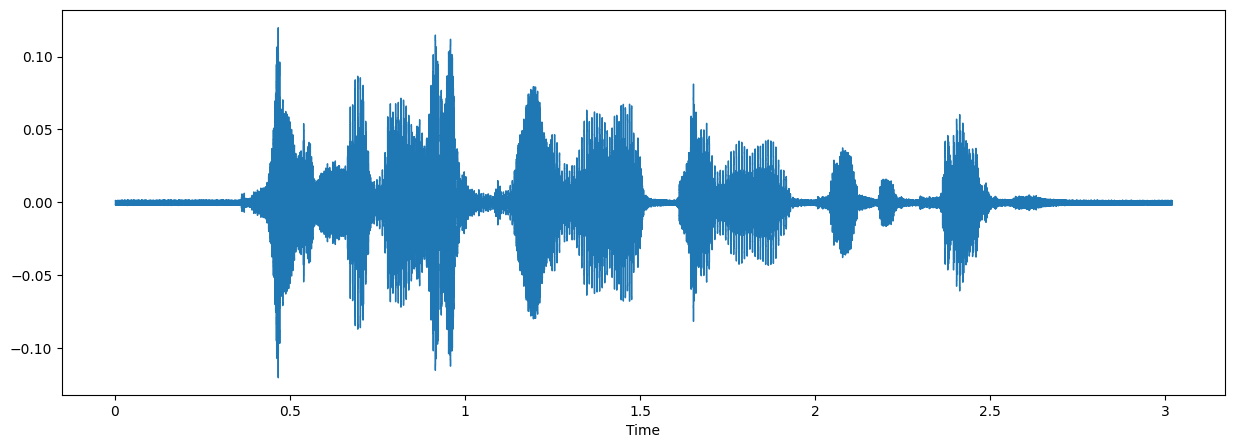

In [112]:
fname = SAVEE + 'KL_su10.wav'
y, sr = librosa.load(fname)

data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio
ipd.Audio(fname)

## RAVDESS dataset

RAVDESS is one of the more common datasets used for this exercise by others. It's well-liked because of its quality of speakers, recording and it has 24 actors of different genders. And there's more! You can get it in song format as well. There's something for everyone and their research project. So for convenience, here's the filename identifiers as per the official RAVDESS website:

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename: `02-01-06-01-02-01-12.mp4`

This means the metadata for the audio file is:

- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement "dogs" (02)
- 1st Repetition (01)
- 12th Actor (12) - Female (as the actor ID number is even)


In [113]:
#RAVDESS
rav_dir = os.listdir(RAVDESS)
rav_dir.sort()

emotion = []
gender = []
path = []
for i in rav_dir:
    fname = os.listdir(RAVDESS + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAVDESS + i + '/' + f)


RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

labels
male_neutral       144
female_neutral     144
male_sad            96
male_angry          96
male_fear           96
male_happy          96
male_surprise       96
male_disgust        96
female_angry        96
female_happy        96
female_sad          96
female_surprise     96
female_fear         96
female_disgust      96
Name: count, dtype: int64

#### RAVDESS Sample Audio

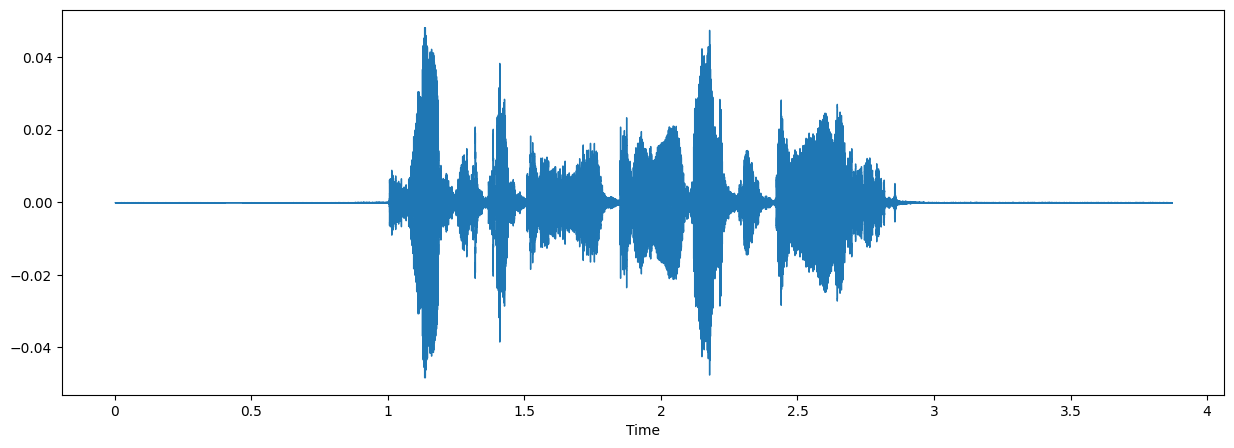

In [114]:
fname = RAVDESS + 'Actor_14/03-01-04-02-01-01-14.wav'
y, sr = librosa.load(fname)

data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio
ipd.Audio(fname)

## CREMA-D

In [115]:
crema_dir = os.listdir(CREMA)
crema_dir.sort()
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in crema_dir:
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)

CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

labels
male_happy        682
male_disgust      678
male_angry        677
male_sad          675
male_fear         673
female_fear       611
female_sad        608
female_angry      606
female_disgust    605
female_happy      602
male_neutral      584
female_neutral    520
Name: count, dtype: int64

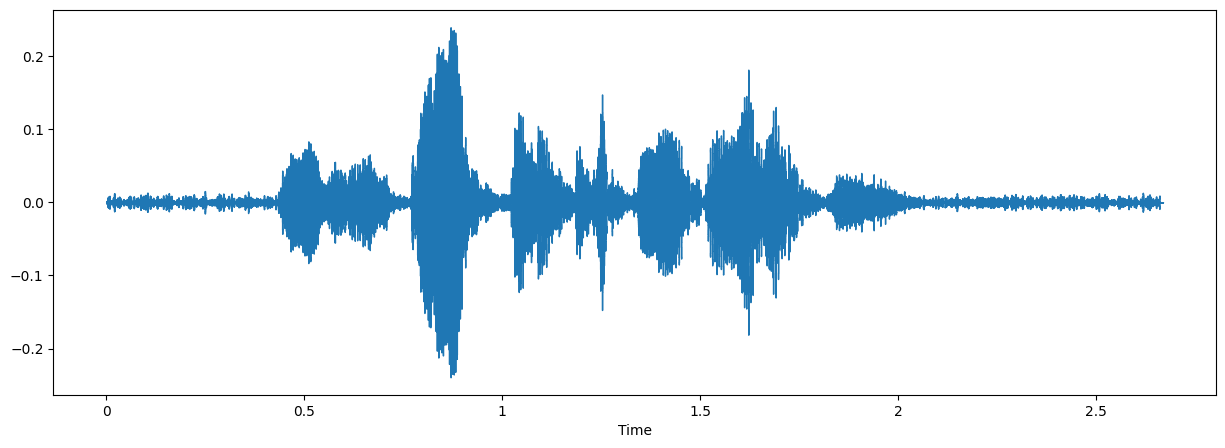

In [116]:
fname = CREMA + '1091_WSI_ANG_XX.wav'
y, sr = librosa.load(fname)

data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio
ipd.Audio(fname)

In [117]:
ser_dataframe = pd.concat([SAVEE_df,RAV_df,CREMA_df], axis = 0)
print(ser_dataframe.labels.value_counts())

labels
male_neutral       848
male_happy         838
male_disgust       834
male_angry         833
male_sad           831
male_fear          829
female_fear        707
female_sad         704
female_angry       702
female_disgust     701
female_happy       698
female_neutral     664
male_surprise      156
female_surprise     96
Name: count, dtype: int64


In [118]:
ser_dataframe['labels'] = ser_dataframe['labels'].str.replace('female_', '').str.replace('male_', '')
ser_dataframe = ser_dataframe[ser_dataframe['labels'] != 'surprise']
ser_dataframe['labels'].value_counts()

labels
happy      1536
fear       1536
disgust    1535
angry      1535
sad        1535
neutral    1512
Name: count, dtype: int64

In [119]:
ser_dataframe.head(5)

,labels,source,path
0,angry,SAVEE,/content/gdrive/MyDrive/BA865 Project Data Fil...
1,angry,SAVEE,/content/gdrive/MyDrive/BA865 Project Data Fil...
2,angry,SAVEE,/content/gdrive/MyDrive/BA865 Project Data Fil...
3,angry,SAVEE,/content/gdrive/MyDrive/BA865 Project Data Fil...
4,angry,SAVEE,/content/gdrive/MyDrive/BA865 Project Data Fil...


## EDA - Jishnu

# Models

## Logistic Regression
## CNN
## Wav2Vec2

## Preprocessing Audio Data

In [120]:
pip install tqdm

In [121]:
from tqdm import tqdm
tqdm.pandas(desc="Processing")
import librosa
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

## Resampling audio to have standard sampling rate for all audio files

In [122]:
def preprocess_audio(filename, target_sr=16000, duration=3):
    audio, sr = librosa.load(filename, sr=None)
    audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    audio = librosa.util.normalize(audio)
    audio, _ = librosa.effects.trim(audio)
    if len(audio) > target_sr * duration:
        audio = audio[:target_sr * duration]
    else:
        audio = np.pad(audio, (0, max(0, target_sr * duration - len(audio))), "constant")
    return audio, target_sr

In [123]:
ser_dataframe = ser_dataframe.reset_index(drop=True)

In [124]:
!pip install -U pandas # upgrade pandas
!pip install swifter # first time installation
!pip install swifter[notebook] # first time installation including dependency for rich progress bar in jupyter notebooks
!pip install swifter[groupby] # first time installation including dependency for groupby.apply functionality

In [125]:
ser_dataframe[['processed_audio', 'sample_rate']] = ser_dataframe['path'].swifter.progress_bar(True).apply(lambda x: preprocess_audio(x)).apply(pd.Series)

Pandas Apply:   0%|          | 0/9189 [00:00<?, ?it/s]

In [128]:
ser_dataframe.head(5)

,labels,source,path,processed_audio,sample_rate
0,angry,SAVEE,/content/gdrive/MyDrive/BA865 Project Data Fil...,"[0.031108191, 0.052095495, 0.04562002, 0.04946...",16000
1,angry,SAVEE,/content/gdrive/MyDrive/BA865 Project Data Fil...,"[0.025315743, 0.043233063, 0.03888655, 0.04122...",16000
2,angry,SAVEE,/content/gdrive/MyDrive/BA865 Project Data Fil...,"[0.025604445, 0.042842522, 0.03748905, 0.04052...",16000
3,angry,SAVEE,/content/gdrive/MyDrive/BA865 Project Data Fil...,"[0.025477534, 0.042815764, 0.037572313, 0.0407...",16000
4,angry,SAVEE,/content/gdrive/MyDrive/BA865 Project Data Fil...,"[0.009087529, 0.015118607, 0.013100795, 0.0141...",16000


In [143]:
# Function to extract features
def extract_features(audio, sr):
    # Generating Mel spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
    S_DB = librosa.power_to_db(S, ref=np.max)

    # Compute MFCCs
    mfccs = librosa.feature.mfcc(S=S, sr=sr, n_mfcc=13)

    # Compute zero crossing rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)

    return S_DB, mfccs, zero_crossing_rate

## Logistic Regression

In [144]:
LR_df = ser_dataframe

In [145]:
# Applying feature extraction function to sampled_df
LR_df['mel_spectrogram'], LR_df['mfccs'], LR_df['zero_crossing_rate'] = zip(*LR_df.progress_apply(lambda x: extract_features(x['processed_audio'], x['sample_rate']), axis=1))
# Reshaping columns
LR_df['mel_spectrogram'] = LR_df['mel_spectrogram'].progress_apply(lambda x: x.reshape(x.shape[0], x.shape[1], 1))
LR_df['mfccs'] = LR_df['mfccs'].progress_apply(lambda x: x.reshape(x.shape[0], x.shape[1], 1))
LR_df['zero_crossing_rate'] = LR_df['zero_crossing_rate'].progress_apply(lambda x: x.reshape(x.shape[0], x.shape[1], 1))

Pandas Apply:   0%|          | 0/9189 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9189 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9189 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9189 [00:00<?, ?it/s]

In [146]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np

label_encoder = LabelEncoder()
LR_df['labels_encoded'] = label_encoder.fit_transform(LR_df['labels'])

labels = to_categorical(LR_df['labels_encoded'])

features = ['processed_audio', 'mfccs', 'mel_spectrogram','zero_crossing_rate']

# Extracting statistical features from sequence columns
processed_features = pd.DataFrame()
for feature in features:
    processed_features[f'{feature}_mean'] = LR_df[feature].apply(np.mean)
    processed_features[f'{feature}_std'] = LR_df[feature].apply(np.std)

X = processed_features
y = LR_df['labels_encoded']

# splitting X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Standardizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#regression model
reg = LogisticRegression()

# fitting the model
model = reg.fit(X_train_scaled, y_train)

# predictions
y_pred = reg.predict(X_test_scaled)

# comparing actual response values (y_test) with predicted response values (y_pred)
print("Logistic Regression model accuracy(in %):", metrics.accuracy_score(y_test, y_pred) * 100)

Logistic Regression model accuracy(in %): 32.58977149075082


In [147]:
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(report)

              precision    recall  f1-score   support

       angry       0.32      0.39      0.35       292
     disgust       0.32      0.36      0.34       313
        fear       0.22      0.20      0.21       297
       happy       0.30      0.41      0.35       321
     neutral       0.42      0.17      0.25       317
         sad       0.44      0.42      0.43       298

    accuracy                           0.33      1838
   macro avg       0.34      0.33      0.32      1838
weighted avg       0.34      0.33      0.32      1838



## CNN

In [148]:
cnn_df = ser_dataframe

In [149]:
def extract_features(audio, sr):
    # Generating Mel spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
    S_DB = librosa.power_to_db(S, ref=np.max)

    # Compute MFCCs
    mfccs = librosa.feature.mfcc(S=S, sr=sr, n_mfcc=13)

    return S_DB, mfccs

In [150]:
cnn_df['mel_spectrogram'], cnn_df['mfccs'] = zip(*cnn_df.progress_apply(lambda x: extract_features(x['processed_audio'], x['sample_rate']), axis=1))
cnn_df['mel_spectrogram'] = cnn_df['mel_spectrogram'].progress_apply(lambda x: x.reshape(x.shape[0], x.shape[1], 1))
cnn_df['mfccs'] = cnn_df['mfccs'].progress_apply(lambda x: x.reshape(x.shape[0], x.shape[1], 1))

Pandas Apply:   0%|          | 0/9189 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9189 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9189 [00:00<?, ?it/s]

In [154]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
cnn_df['labels_encoded'] = label_encoder.fit_transform(cnn_df['labels'])

labels = to_categorical(cnn_df['labels_encoded'])

X_train, X_test, y_train, y_test = train_test_split(cnn_df[['mel_spectrogram', 'mfccs']], labels, test_size=0.2, random_state=42)

In [155]:
X_train_mel = np.stack(X_train['mel_spectrogram'].values)
X_test_mel = np.stack(X_test['mel_spectrogram'].values)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [185]:
input_shape = X_train_mel.shape[1:]
num_classes = y_train.shape[1]

In [157]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00


In [158]:
  import wandb
  wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [204]:
from wandb.keras import WandbCallback
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

# Initialize a new wandb run
wandb.init(project='BA865_Project', entity='bostonuyash')

# Define the configuration dynamically
wandb.config = {
  "learning_rate": 0.0001,
  "epochs": 20,
  "batch_size": 32
}

accuracy,▁▂▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
val_accuracy,▃▁▅▃▄▆▇▇▅▅▆▇▇▇███▆█▇
val_loss,▄█▃▄▄▂▁▂▄▃▃▂▁▂▁▂▂▅▂▃
accuracy,0.79472
best_epoch,14
best_val_loss,1.11157
epoch,19
loss,0.53795
val_accuracy,0.5506


In [196]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, ReLU
from tensorflow.keras.regularizers import l2

def create_cnn(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Additional conv block
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.1)(x)

    # Additional conv block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.1)(x)

    # Second conv block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.1)(x)

    # Third conv block
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)

    # Fourth conv block
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)

    # Fifth conv block

    x = Flatten()(x)
    x = Dense(256,activation='relu')(x)
    x = Dropout(0.2)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(input_layer, output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [197]:
model = create_cnn(input_shape, num_classes)

history = model.fit(X_train_mel, y_train,
                    epochs=wandb.config['epochs'],
                    batch_size=wandb.config['batch_size'],
                    validation_data=(X_test_mel, y_test),
                    callbacks=[WandbCallback()])

Epoch 1/20
229/230 [============================>.] - ETA: 0s - loss: 1.7077 - accuracy: 0.3369

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240425_083949-p7rhhdl7/files/model-best)... Done. 0.0s


230/230 [==============================] - 9s 23ms/step - loss: 1.7075 - accuracy: 0.3367 - val_loss: 1.6826 - val_accuracy: 0.3259
Epoch 2/20
230/230 [==============================] - 2s 10ms/step - loss: 1.4706 - accuracy: 0.4066 - val_loss: 2.5643 - val_accuracy: 0.2291
Epoch 3/20
229/230 [============================>.] - ETA: 0s - loss: 1.3904 - accuracy: 0.4460

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240425_083949-p7rhhdl7/files/model-best)... Done. 0.0s


230/230 [==============================] - 5s 22ms/step - loss: 1.3916 - accuracy: 0.4459 - val_loss: 1.5279 - val_accuracy: 0.4189
Epoch 4/20
230/230 [==============================] - 2s 10ms/step - loss: 1.2945 - accuracy: 0.4878 - val_loss: 1.6487 - val_accuracy: 0.3341
Epoch 5/20
230/230 [==============================] - 2s 10ms/step - loss: 1.2362 - accuracy: 0.5216 - val_loss: 1.6877 - val_accuracy: 0.3787
Epoch 6/20
229/230 [============================>.] - ETA: 0s - loss: 1.1862 - accuracy: 0.5416

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240425_083949-p7rhhdl7/files/model-best)... Done. 0.0s


230/230 [==============================] - 5s 21ms/step - loss: 1.1865 - accuracy: 0.5417 - val_loss: 1.2802 - val_accuracy: 0.5054
Epoch 7/20
229/230 [============================>.] - ETA: 0s - loss: 1.1431 - accuracy: 0.5584

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240425_083949-p7rhhdl7/files/model-best)... Done. 0.0s


230/230 [==============================] - 6s 24ms/step - loss: 1.1435 - accuracy: 0.5579 - val_loss: 1.1615 - val_accuracy: 0.5462
Epoch 8/20
230/230 [==============================] - 2s 10ms/step - loss: 1.0778 - accuracy: 0.5847 - val_loss: 1.2588 - val_accuracy: 0.5261
Epoch 9/20
230/230 [==============================] - 2s 10ms/step - loss: 1.0432 - accuracy: 0.5980 - val_loss: 1.6933 - val_accuracy: 0.4157
Epoch 10/20
230/230 [==============================] - 2s 10ms/step - loss: 1.0038 - accuracy: 0.6158 - val_loss: 1.4836 - val_accuracy: 0.4516
Epoch 11/20
230/230 [==============================] - 2s 10ms/step - loss: 0.9462 - accuracy: 0.6391 - val_loss: 1.5051 - val_accuracy: 0.4973
Epoch 12/20
230/230 [==============================] - 2s 10ms/step - loss: 0.9031 - accuracy: 0.6545 - val_loss: 1.3723 - val_accuracy: 0.5218
Epoch 13/20
230/230 [==============================] - 2s 10ms/step - loss: 0.8532 - accuracy: 0.6712 - val_loss: 1.2105 - val_accuracy: 0.5544
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240425_083949-p7rhhdl7/files/model-best)... Done. 0.0s


230/230 [==============================] - 5s 22ms/step - loss: 0.7724 - accuracy: 0.7043 - val_loss: 1.1116 - val_accuracy: 0.5881
Epoch 16/20
230/230 [==============================] - 2s 10ms/step - loss: 0.7289 - accuracy: 0.7215 - val_loss: 1.3004 - val_accuracy: 0.5669
Epoch 17/20
230/230 [==============================] - 2s 10ms/step - loss: 0.6750 - accuracy: 0.7468 - val_loss: 1.2820 - val_accuracy: 0.5892
Epoch 18/20
230/230 [==============================] - 2s 10ms/step - loss: 0.6546 - accuracy: 0.7526 - val_loss: 1.9301 - val_accuracy: 0.4875
Epoch 19/20
230/230 [==============================] - 2s 10ms/step - loss: 0.5960 - accuracy: 0.7750 - val_loss: 1.2387 - val_accuracy: 0.5876
Epoch 20/20
230/230 [==============================] - 2s 10ms/step - loss: 0.5380 - accuracy: 0.7947 - val_loss: 1.5677 - val_accuracy: 0.5506


In [199]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 9.7 MB/s eta 0:00:00


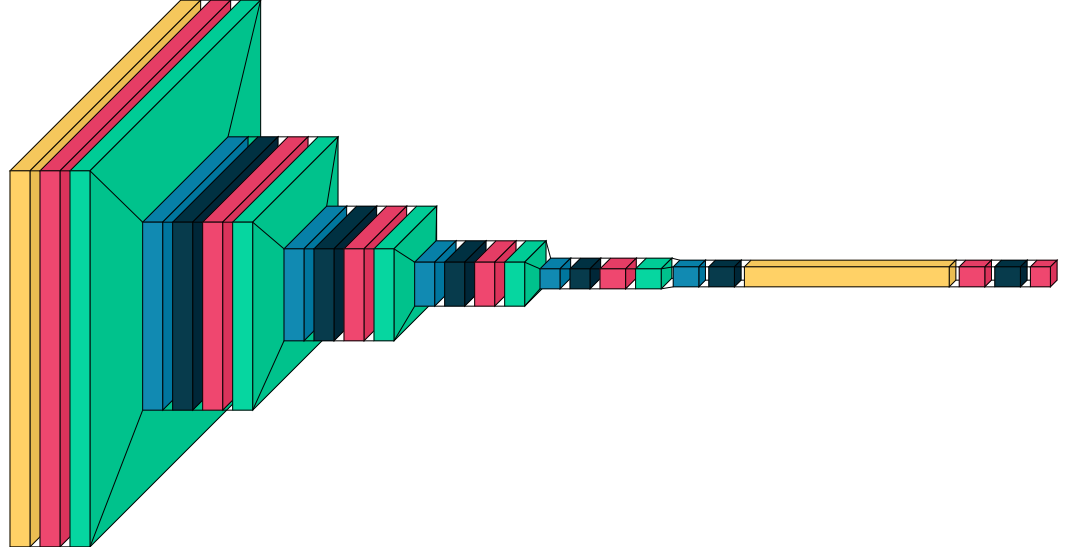

In [202]:
import visualkeras

model = model

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

## Wav2Vec2

In [205]:
! pip install -U accelerate
! pip install -U transformers
! pip install datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [234]:
wav2vec2_df = ser_dataframe[['labels','source','path','processed_audio','sample_rate']]

In [235]:
from transformers import AutoFeatureExtractor
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:363: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [236]:
wav2vec2_df.head(3)

,labels,source,path,processed_audio,sample_rate
0,angry,SAVEE,/content/gdrive/MyDrive/BA865 Project Data Fil...,"[0.031108191, 0.052095495, 0.04562002, 0.04946...",16000
1,angry,SAVEE,/content/gdrive/MyDrive/BA865 Project Data Fil...,"[0.025315743, 0.043233063, 0.03888655, 0.04122...",16000
2,angry,SAVEE,/content/gdrive/MyDrive/BA865 Project Data Fil...,"[0.025604445, 0.042842522, 0.03748905, 0.04052...",16000


In [237]:
from datasets import Dataset
dataset = Dataset.from_pandas(wav2vec2_df)
dataset = dataset.class_encode_column("labels")

Casting to class labels:   0%|          | 0/9189 [00:00<?, ? examples/s]

In [239]:
dataset.info

DatasetInfo(description='', citation='', homepage='', license='', features={'labels': ClassLabel(names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'], id=None), 'source': Value(dtype='string', id=None), 'path': Value(dtype='string', id=None), 'processed_audio': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), 'sample_rate': Value(dtype='int64', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name=None, dataset_name=None, config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None)

In [238]:
labels = dataset['labels']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [240]:
def preprocess_function(examples):
    # Directly take audio data arrays from examples
    audio_arrays = examples["processed_audio"]
    # Process these arrays with your feature extractor
    inputs = feature_extractor(
        audio_arrays, sampling_rate=16000, max_length=16000, truncation=True
    )
    # Return processed inputs
    return inputs

In [241]:
from datasets import Dataset, DatasetDict


split_datasets = dataset.train_test_split(test_size=0.2)

# Creating a DatasetDict for better handling
encoded_dataset = DatasetDict({
    'train': split_datasets['train'],
    'validation': split_datasets['test']
})


In [242]:
encoded_dataset = dataset.map(preprocess_function, remove_columns=["processed_audio", "path","source","sample_rate"], batched=True)
encoded_dataset

Map:   0%|          | 0/9189 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_values'],
    num_rows: 9189
})

In [246]:
import evaluate

accuracy = evaluate.load("accuracy")

In [247]:
import numpy as np


def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

In [248]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=num_labels, label2id=label2id, id2label=id2label
)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [249]:
from huggingface_hub import notebook_login

notebook_login()

In [252]:
from datasets import Dataset, DatasetDict


split_datasets = encoded_dataset.train_test_split(test_size=0.2)

# Creating a DatasetDict for better handling
encoded_dataset = DatasetDict({
    'train': split_datasets['train'],
    'validation': split_datasets['test']
})


# Now you can access the subsets as you have shown
train_dataset = encoded_dataset["train"]
eval_dataset = encoded_dataset["validation"]

In [253]:
encoded_dataset["train"].features["labels"]

ClassLabel(names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'], id=None)

In [254]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_values'],
        num_rows: 7351
    })
    validation: Dataset({
        features: ['labels', 'input_values'],
        num_rows: 1838
    })
})

In [261]:
import os
os.environ["WANDB_PROJECT"]="BA865_Wav2Vec2"

In [263]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="wandb",
    run_name="base-wav2vec2",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=feature_extractor,  # Ensure this is the same processor used for preprocessing
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,3.714500,3.245737,0.151795
2,1.676000,1.633701,0.405876
4,1.486300,1.467975,0.454842
6,1.363200,1.414348,0.466812
8,1.279100,1.392470,0.476605
9,1.260400,1.405493,0.470076


TrainOutput(global_step=570, training_loss=1.8074295746652704, metrics={'train_runtime': 1313.6592, 'train_samples_per_second': 55.958, 'train_steps_per_second': 0.434, 'total_flos': 6.78160543581216e+17, 'train_loss': 1.8074295746652704, 'epoch': 9.91304347826087})

In [264]:
trainer.evaluate()

{'eval_loss': 1.392470359802246,
 'eval_accuracy': 0.4766050054406964,
 'eval_runtime': 16.9544,
 'eval_samples_per_second': 108.408,
 'eval_steps_per_second': 3.421,
 'epoch': 9.91304347826087}

In [273]:
from datasets import load_dataset, Audio

from datasets import load_dataset

inference = load_dataset("narad/ravdess")

ImportError: cannot import name 'SequenceNotStr' from 'pandas._typing' (/usr/local/lib/python3.10/dist-packages/pandas/_typing.py)

In [274]:
#inference = load_dataset("PolyAI/minds14", name="en-US", split="train")
inference = inference.cast_column("audio", Audio(sampling_rate=16000))
sampling_rate = inference.features["audio"].sampling_rate
audio_file = inference[0]["audio"]["path"]

In [275]:
from transformers import pipeline

classifier = pipeline("audio-classification", model="yranawat/results")
classifier(audio_file)

[{'score': 0.23085369169712067, 'label': 0},
 {'score': 0.21356840431690216, 'label': 0},
 {'score': 0.19223612546920776, 'label': 0},
 {'score': 0.1597384214401245, 'label': 0},
 {'score': 0.09941030293703079, 'label': 0}]

## Sweep for CNN

In [276]:
sweep_config = {
    'method': 'random',  # You can use "grid", "random" or "bayesian"
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'min': 1e-5,
            'max': 1e-3
        },
        'dropout_rate': {
            'values': [0.1, 0.2, 0.3]
        },
        'batch_size': {
            'values': [16, 32, 64]
        }
    }
}

In [277]:
import wandb
sweep_id = wandb.sweep(sweep_config, project='BA865_Project', entity='bostonuyash')

Create sweep with ID: x8em1vpu
Sweep URL: https://wandb.ai/bostonuyash/BA865_Project/sweeps/x8em1vpu


In [278]:
def train():
    # Initialize a wandb run
    wandb.init()

    # Access sweep parameters
    config = wandb.config

    model = create_cnn(input_shape, num_classes, config.dropout_rate)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train_mel, y_train,
                        epochs=20,  # You can also make epochs a sweep parameter
                        batch_size=config.batch_size,
                        validation_data=(X_test_mel, y_test),
                        callbacks=[WandbCallback()])



In [279]:
wandb.agent(sweep_id, train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: nlu2j74j with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.3
wandb: 	learning_rate: 0.00023651931163355135


wandb: ERROR Run nlu2j74j errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 308, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "<ipython-input-278-b94d428af02a>", line 8, in train
wandb: ERROR     model = create_cnn(input_shape, num_classes, config.dropout_rate)
wandb: ERROR TypeError: create_cnn() takes 2 positional arguments but 3 were given
wandb: ERROR 
wandb: Agent Starting Run: csh1ttu5 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	learning_rate: 0.0008034348955408497


wandb: ERROR Run csh1ttu5 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 308, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "<ipython-input-278-b94d428af02a>", line 8, in train
wandb: ERROR     model = create_cnn(input_shape, num_classes, config.dropout_rate)
wandb: ERROR TypeError: create_cnn() takes 2 positional arguments but 3 were given
wandb: ERROR 
wandb: Ctrl + C detected. Stopping sweep.
